In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

In [2]:
#random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Loading
file_path = './TSLA.csv'
tsla_data = pd.read_csv(file_path)

# Converting 'Date' to datetime and set as index
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])
tsla_data.set_index('Date', inplace=True)

# Selecting
features = ['Close', 'Volume']
tsla_features = tsla_data[features].copy()

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(tsla_features)

# create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - 1):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Creating sequences with a given sequence length
sequence_length = 20  # Days of data in the sequences
X, y = create_sequences(scaled_features, sequence_length)

# Shuffle for bias prevention
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Get the dates for the test set (as the last date of each sequence)
test_dates = tsla_data.index[train_size + sequence_length:][:len(X_test)]

# Build
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, len(features)),
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))  # Added L1 and L2 regularization
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Set your custom learning rate here
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1  # Set to 1 for more verbosity
)

# Evaluate
loss = model.evaluate(X_test, y_test, verbose=0)

# Predicting
predicted_stock_price = model.predict(X_test)

# Inverse transform the predictions and actuals
predicted_stock_price = scaler.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], len(features) - 1))), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

Epoch 1/100
28/28 [==============================] - 3s 35ms/step - loss: 0.0422 - val_loss: 0.0223
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0160
Epoch 3/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0161 - val_loss: 0.0129
Epoch 4/100
28/28 [==============================] - 0s 14ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 5/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 6/100
28/28 [==============================] - 1s 18ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 7/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0090 - val_loss: 0.0072
Epoch 8/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 9/100
28/28 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 10/100
28/28 [==============================] - 0s 15ms/step - loss: 0.0072 - val_loss: 0.0058

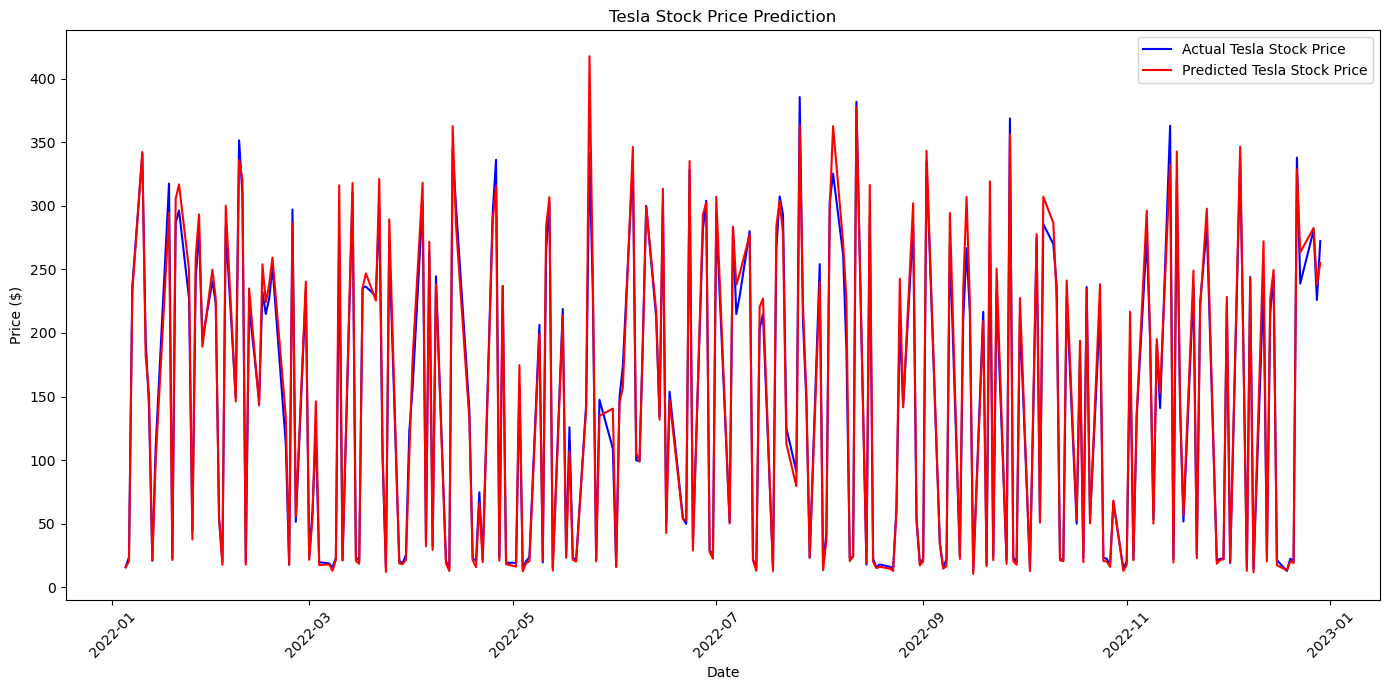

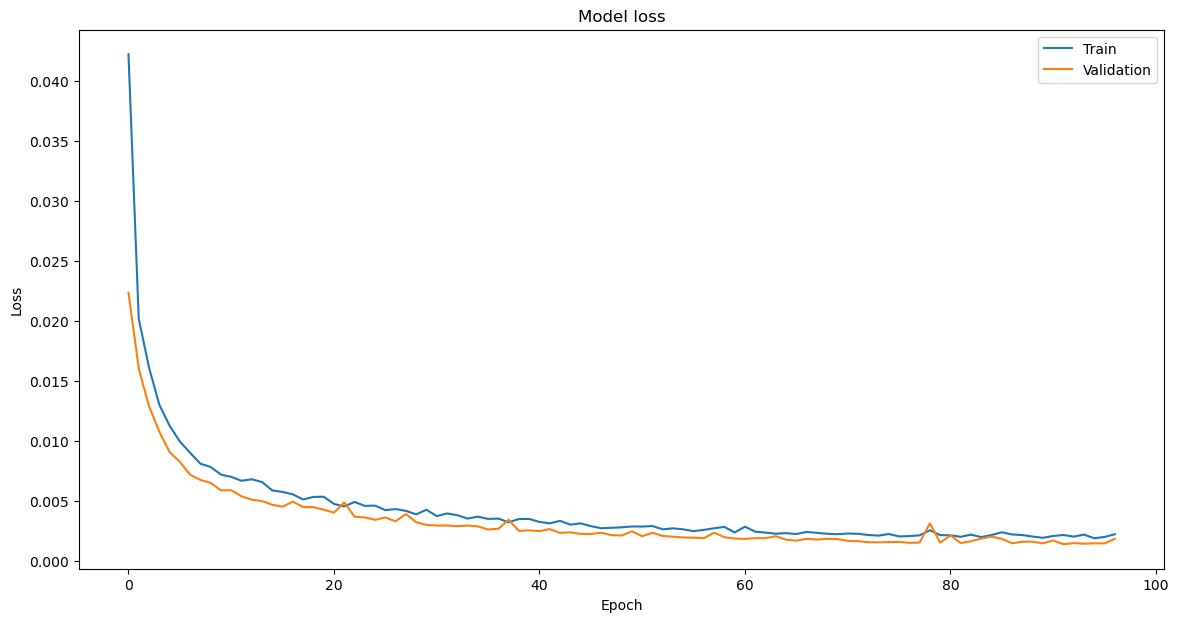

Mean Absolute Error (MAE): 8.455143507990392
Mean Squared Error (MSE): 164.703944510146
Root Mean Squared Error (RMSE): 12.833703460425832
Mean Absolute Percentage Error (MAPE): 7.455352751116617%


In [3]:
# Plot the actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_unscaled, color='blue', label='Actual Tesla Stock Price')
plt.plot(test_dates, predicted_stock_price, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
# Calculate error metrics
mape = calculate_mape(y_test_unscaled, predicted_stock_price)
mae = mean_absolute_error(y_test_unscaled, predicted_stock_price)
mse = mean_squared_error(y_test_unscaled, predicted_stock_price)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')